#### Выгрузка данных и первичный анализ

In [2]:
from dotenv import load_dotenv
import os
import requests as rq
import numpy as np
import pandas as pd
#import re
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import objects as so

#v = rq.get('https://data-charts-api.hexlet.app/visits?begin=2023-03-01&end=2023-09-01')
#r = rq.get('https://data-charts-api.hexlet.app/registrations?begin=2023-03-01&end=2023-09-01')
#v = v.json()
#r = r.json()
#visits = pd.DataFrame(v)
#regs = pd.DataFrame(r)

In [85]:
#API_URL='https://data-charts-api.hexlet.app'
#DATE_BEGIN='2023-03-01'
#DATE_END='2023-09-01'

In [91]:
load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

current_dir = os.getcwd() 
charts_folder = os.path.join(current_dir, 'charts')

if not os.path.exists(charts_folder):
    os.makedirs(charts_folder)

v = rq.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})
r = rq.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})

visits = pd.DataFrame(v.json())
regs = pd.DataFrame(r.json())

In [12]:
visits.describe()

,visit_id,platform,user_agent,datetime
count,263459,263459,263459,263459
unique,146085,4,32,261204
top,64167edd-323a-4ab0-be9b-acd237a1ac30,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-07-06T10:45:50
freq,4,236301,13623,3


In [13]:
regs.describe()

,datetime,user_id,email,platform,registration_type
count,21836,21836,21836,21836,21836
unique,21821,21836,20868,3,4
top,2023-06-23T13:10:45,2e0f6bb8-b029-4f45-a786-2b53990d37f1,ujones@example.com,android,email
freq,2,1,6,10582,8996


# Конверсия

#### Очистка от ботов

In [14]:
visits = visits.drop(visits[visits['platform'] == 'bot'].index)
visits.describe()

,visit_id,platform,user_agent,datetime
count,256077,256077,256077,256077
unique,138703,3,28,253950
top,cd15bcd0-5d8b-4a06-98d6-57a0667648f3,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-04-16T02:26:40
freq,4,236301,13623,3


#### Отбор последних визитов пользователей

In [15]:
visits_last = visits.sort_values('datetime').groupby('visit_id').tail(1)
visits_last.describe()

,visit_id,platform,user_agent,datetime
count,138703,138703,138703,138703
unique,138703,3,28,138061
top,348148db-9841-4b42-a0e1-7631f4667f83,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-04-20T04:40:13
freq,1,118927,6845,3


#### Объединение данных визитов по дате и платформе

In [16]:
visits_last['date_group'] = pd.to_datetime(visits['datetime']).dt.date
visits_agr = visits_last.drop(['datetime', 'user_agent'], axis=1)
visits_agr = visits_agr.groupby(['date_group', 'platform']).agg(visits = ('visit_id', 'count'))
visits_agr = visits_agr.reset_index()
visits_agr.head(200)

,date_group,platform,visits
0,2023-03-01,android,75
1,2023-03-01,ios,22
2,2023-03-01,web,279
3,2023-03-02,android,67
4,2023-03-02,ios,31
...,...,...,...
195,2023-05-05,android,108
196,2023-05-05,ios,15
197,2023-05-05,web,493
198,2023-05-06,android,64


#### Объединение данных регистрации по дате и платформе

In [57]:
regs['date_group'] = pd.to_datetime(regs['datetime']).dt.date
regs_agr = regs.drop(['datetime', 'email', 'registration_type'], axis=1)
regs_agr = regs_agr.groupby(['date_group', 'platform']).agg(registrations = ('user_id', 'count'))
regs_agr = regs_agr.reset_index()
regs_agr.head(200)

,date_group,platform,registrations
0,2023-03-01,android,61
1,2023-03-01,ios,18
2,2023-03-01,web,8
3,2023-03-02,android,59
4,2023-03-02,ios,24
...,...,...,...
195,2023-05-05,android,94
196,2023-05-05,ios,11
197,2023-05-05,web,35
198,2023-05-06,android,61


#### Объединение датафреймов

In [18]:
convers = pd.merge(left=visits_agr, right=regs_agr, on=('date_group', 'platform'))
convers['conversion'] = convers['registrations'] * 100 / convers['visits']
print(convers)

     date_group platform  visits  registrations  conversion
0    2023-03-01  android      75             61   81.333333
1    2023-03-01      ios      22             18   81.818182
2    2023-03-01      web     279              8    2.867384
3    2023-03-02  android      67             59   88.059701
4    2023-03-02      ios      31             24   77.419355
..          ...      ...     ...            ...         ...
547  2023-08-30      ios      66             40   60.606061
548  2023-08-30      web    1227             34    2.770986
549  2023-08-31  android      57             42   73.684211
550  2023-08-31      ios      50             36   72.000000
551  2023-08-31      web     721             46    6.380028

[552 rows x 5 columns]


In [19]:
convers.to_json('./conversion.json')

# Реклама

In [20]:
ads = pd.read_csv('ads.csv')
ads.head()

,date,utm_source,utm_medium,utm_campaign,cost
0,2023-03-01T10:54:41,google,cpc,advanced_algorithms_series,212
1,2023-03-02T10:32:35,google,cpc,advanced_algorithms_series,252
2,2023-03-03T19:21:40,google,cpc,advanced_algorithms_series,202
3,2023-03-04T17:52:04,google,cpc,advanced_algorithms_series,223
4,2023-03-05T05:35:13,google,cpc,advanced_algorithms_series,265


In [21]:
ads['date_group'] = pd.to_datetime(ads['date']).dt.date
ads = ads.drop(['date', 'utm_source', 'utm_medium'], axis=1)
ads.head()

,utm_campaign,cost,date_group
0,advanced_algorithms_series,212,2023-03-01
1,advanced_algorithms_series,252,2023-03-02
2,advanced_algorithms_series,202,2023-03-03
3,advanced_algorithms_series,223,2023-03-04
4,advanced_algorithms_series,265,2023-03-05


In [22]:
convers_cut = convers.drop(['platform', 'conversion'], axis=1)
ads_full = pd.merge(convers_cut, ads, on='date_group')
ads_full['cost'] =ads_full['cost'].fillna(0)
ads_full['utm_campaign'] =ads_full['utm_campaign'].fillna('none')
print(ads_full)

     date_group  visits  registrations                utm_campaign  cost
0    2023-03-01      75             61  advanced_algorithms_series   212
1    2023-03-01      22             18  advanced_algorithms_series   212
2    2023-03-01     279              8  advanced_algorithms_series   212
3    2023-03-02      67             59  advanced_algorithms_series   252
4    2023-03-02      31             24  advanced_algorithms_series   252
..          ...     ...            ...                         ...   ...
421  2023-08-30      66             40      intro_to_python_course   109
422  2023-08-30    1227             34      intro_to_python_course   109
423  2023-08-31      57             42      intro_to_python_course   215
424  2023-08-31      50             36      intro_to_python_course   215
425  2023-08-31     721             46      intro_to_python_course   215

[426 rows x 5 columns]


#### Объединение конверсий с рекламой

In [23]:
conv_ads = pd.merge(convers, ads_full, on=('date_group', 'visits', 'registrations'))
conv_ads.head()

,date_group,platform,visits,registrations,conversion,utm_campaign,cost
0,2023-03-01,android,75,61,81.333333,advanced_algorithms_series,212
1,2023-03-01,ios,22,18,81.818182,advanced_algorithms_series,212
2,2023-03-01,web,279,8,2.867384,advanced_algorithms_series,212
3,2023-03-02,android,67,59,88.059701,advanced_algorithms_series,252
4,2023-03-02,ios,31,24,77.419355,advanced_algorithms_series,252


In [24]:
conv_ads.to_json('./ads.json')

# Визуализация

#### Создаем папку charts

In [3]:
#direct = os.getcwd()
#if not os.path.exists(direct):
#    os.mkdir('charts')
#else:
#    print(f"Папка 'charts' уже существует")

Папка 'charts' уже существует


#### График общих визитов

In [47]:
visits_agr = visits_agr.drop(['platform'], axis=1).groupby('date_group').sum().reset_index()
print(first_visits)

    date_group  visits
0   2023-03-01     376
1   2023-03-02     613
2   2023-03-03     683
3   2023-03-04     647
4   2023-03-05     707
..         ...     ...
56  2023-04-26     620
57  2023-04-27     922
58  2023-04-28     900
59  2023-04-29     807
60  2023-04-30     895

[61 rows x 2 columns]


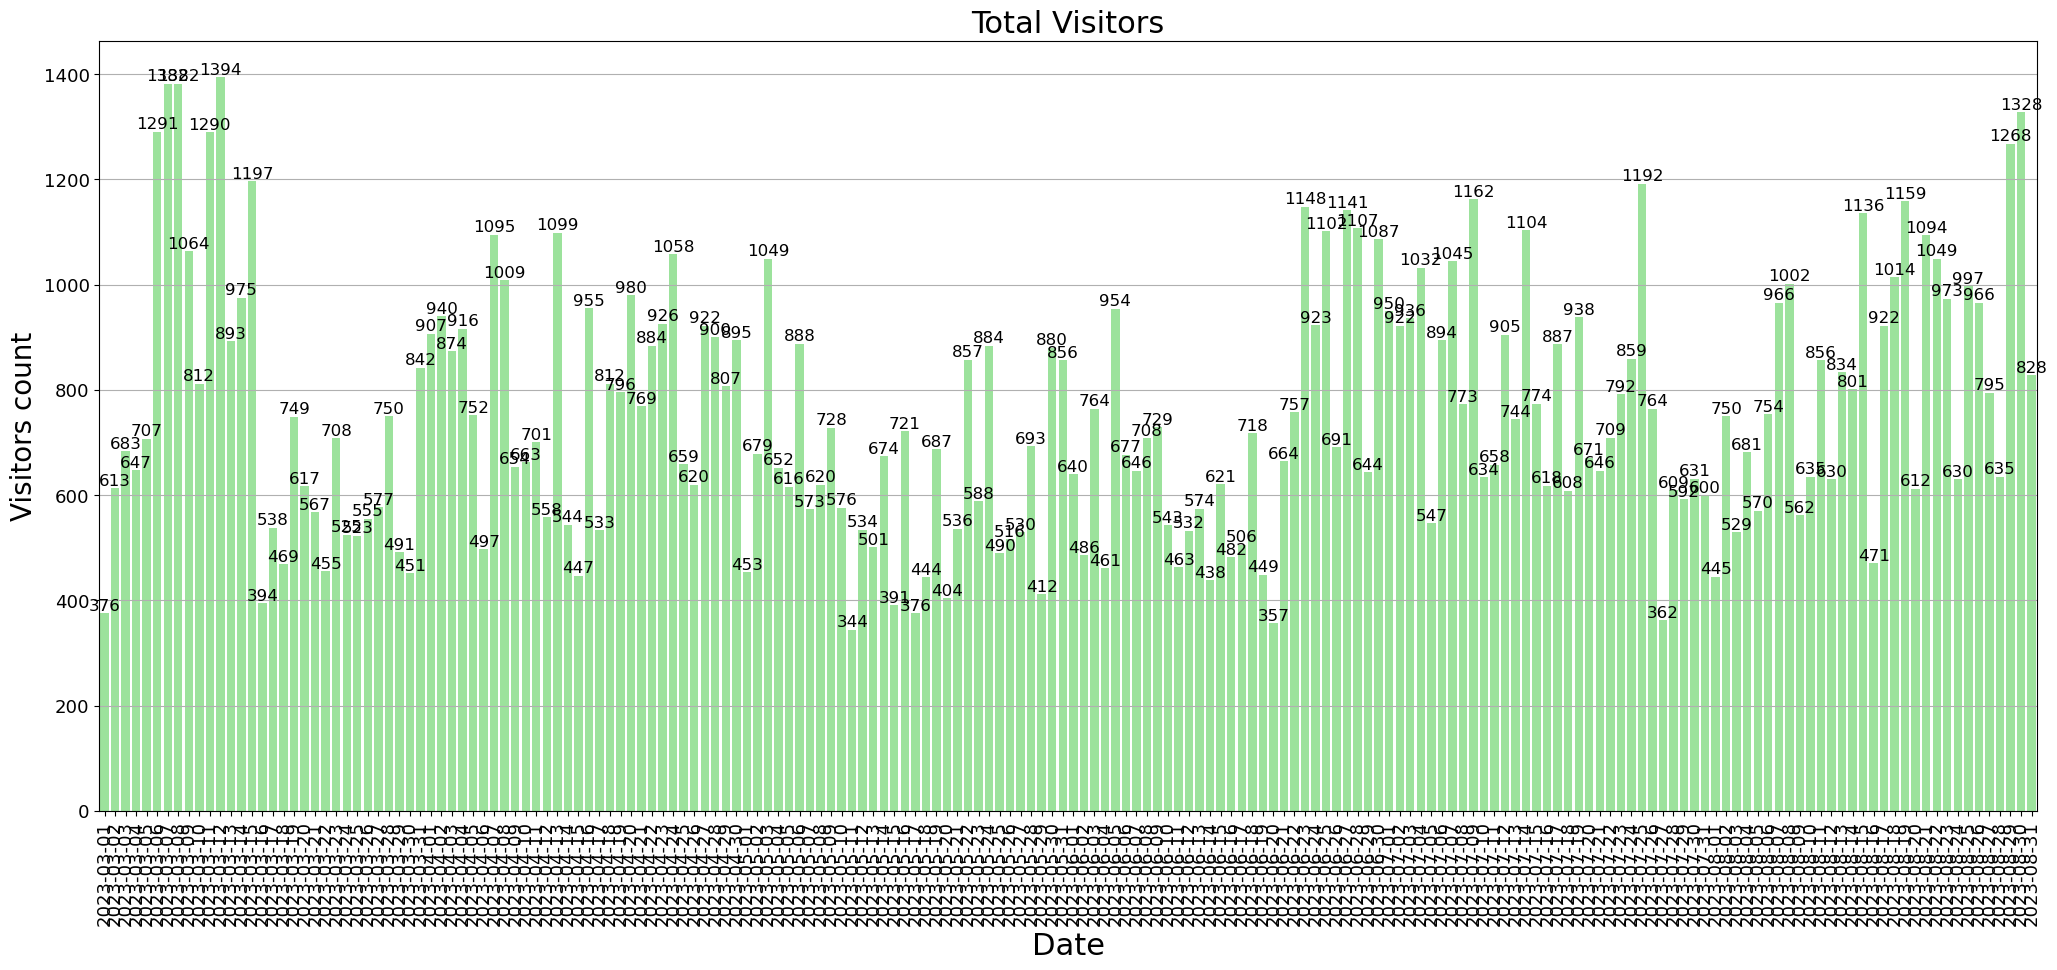

In [48]:
plt.figure(figsize=(25,10))
splot = sns.barplot(data=visits_agr, x='date_group', y='visits', color='lightgreen', errorbar = None)

plt.xlabel('Date', size=22)
plt.ylabel('Visitors count', size=20)
plt.title('Total Visitors', size=22)
plt.xticks(rotation=90, size=13)
plt.yticks(size=13)
plt.grid(axis='y')
plt.bar_label(splot.containers[0], size=12)

plt.savefig('./charts/visits_by_date.png')
plt.show()

#### Визиты по платформам

In [49]:
convers['conversion'] = convers['conversion'].astype(int)

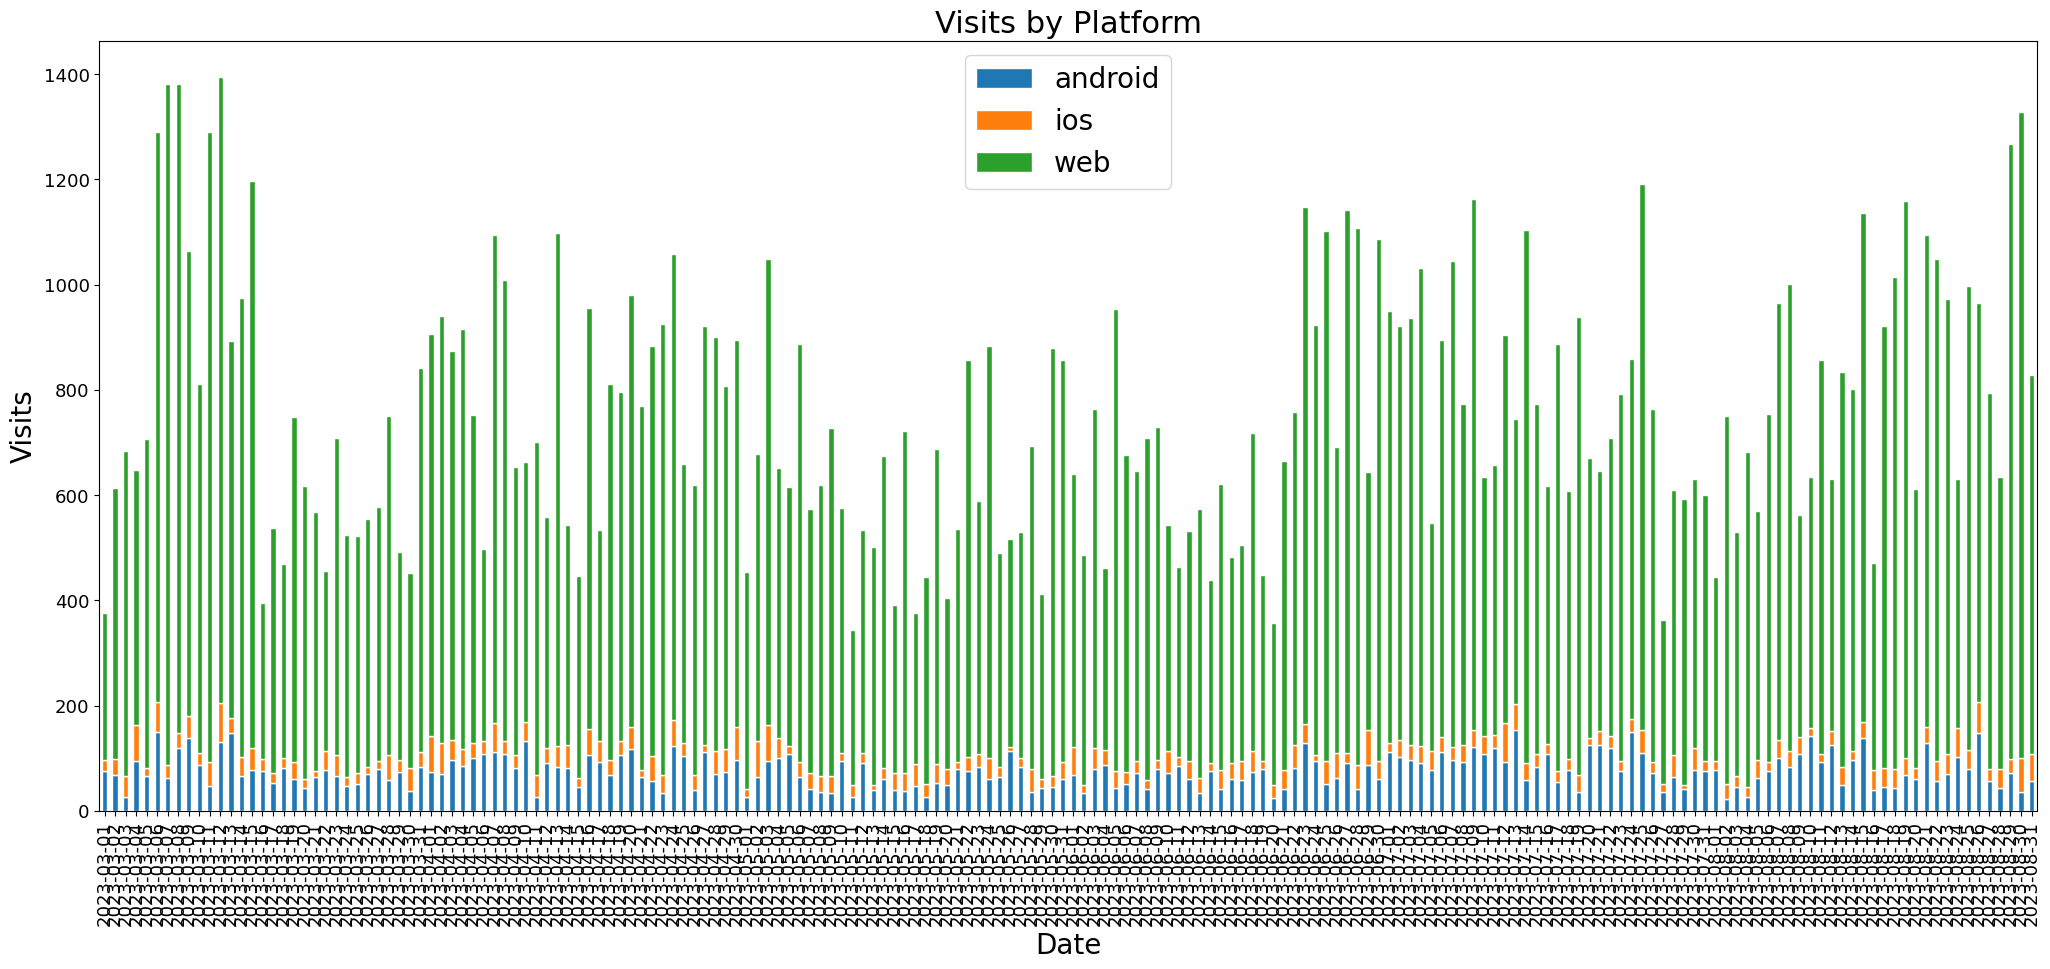

In [51]:
con = convers.pivot_table(values='visits', index='date_group', columns='platform', aggfunc='sum', fill_value=0)

fig, ax = plt.subplots(figsize=(25, 10))
con.plot(kind='bar', stacked=True, ax=ax, edgecolor='white')

ax.set_xlabel('Date', size=20)
ax.set_ylabel('Visits', size=20)
ax.set_title('Visits by Platform', size=22)
plt.yticks(size=13)
plt.legend(fontsize=20)
plt.xticks(rotation=90, size=13)

plt.savefig('./charts/visits_by_platform.png')
plt.show()

#### График регистраций

In [58]:
regs_agr = regs_agr.drop(['platform'], axis=1).groupby('date_group').sum().reset_index()
print(regs_agr)

     date_group  registrations
0    2023-03-01             87
1    2023-03-02            106
2    2023-03-03            107
3    2023-03-04            159
4    2023-03-05            115
..          ...            ...
179  2023-08-27             88
180  2023-08-28             83
181  2023-08-29            143
182  2023-08-30            101
183  2023-08-31            124

[184 rows x 2 columns]


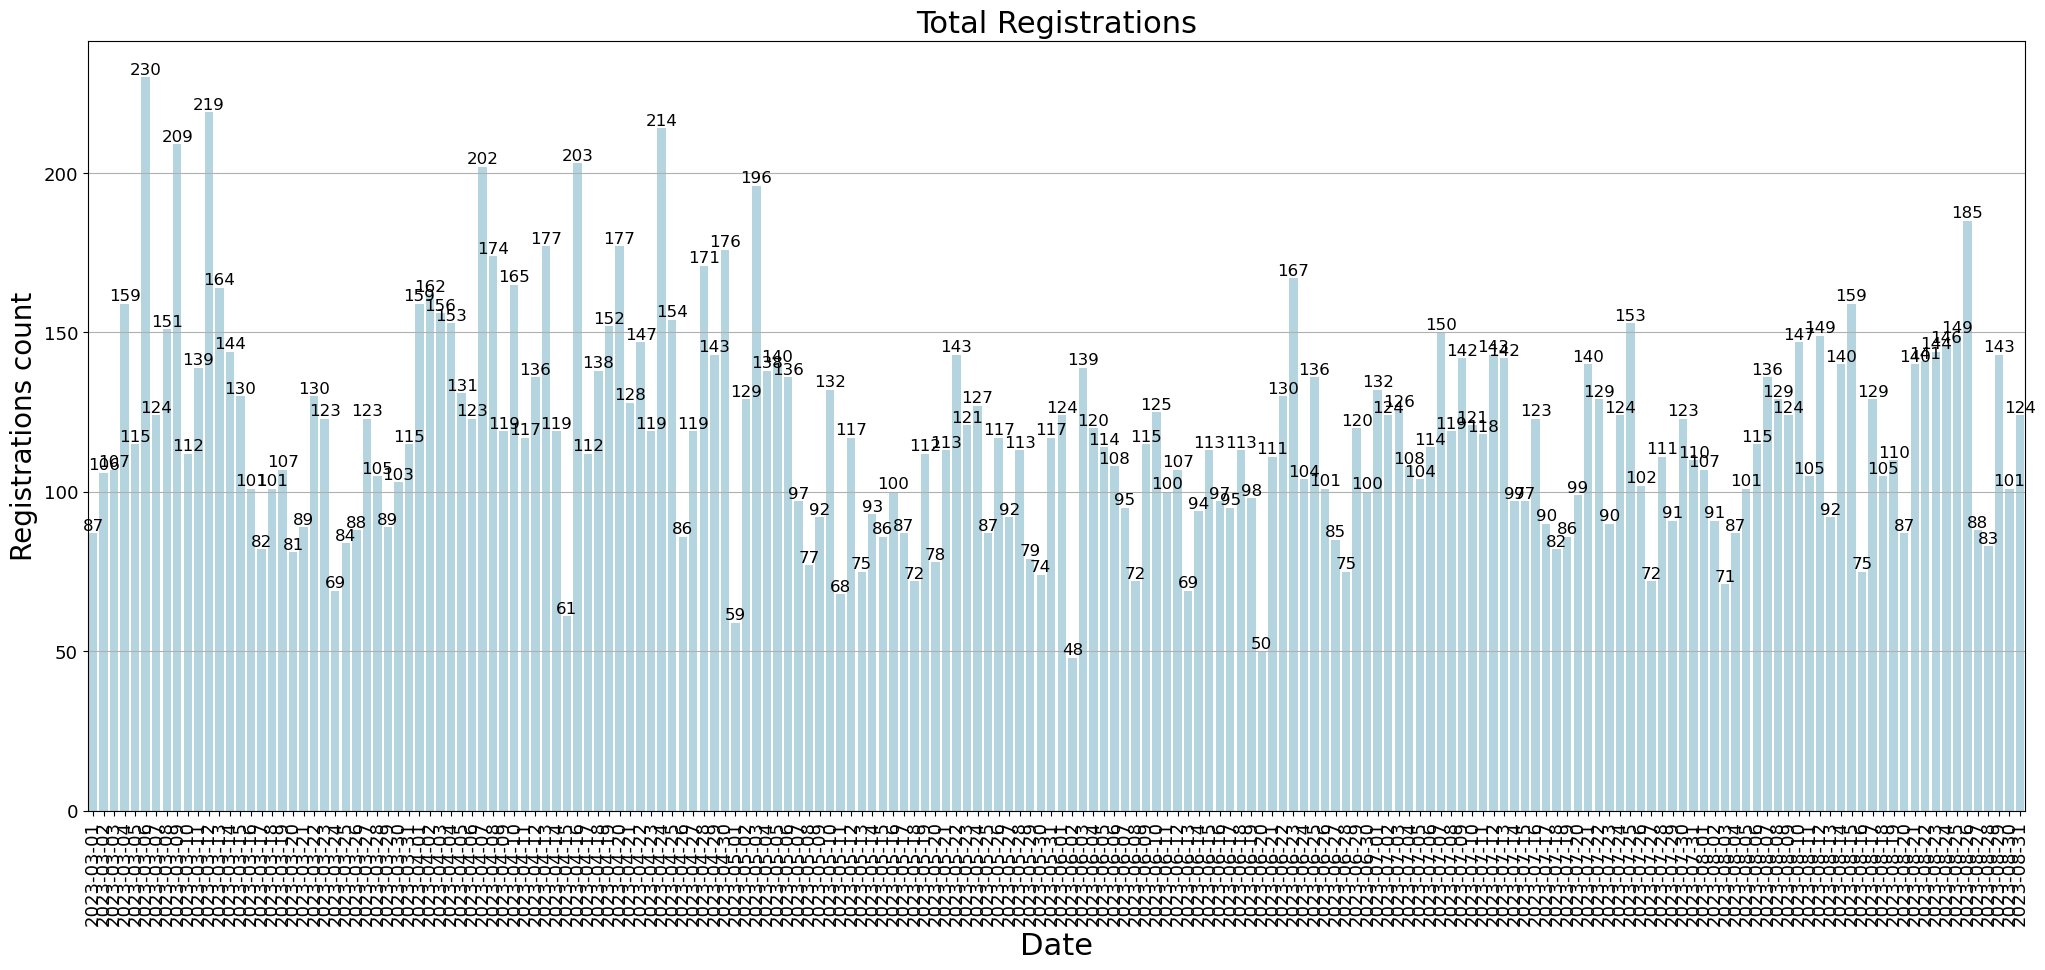

In [109]:
plt.figure(figsize=(25,10))
splot2 = sns.barplot(data=regs_agr, x='date_group', y='registrations', color='lightblue', errorbar = None)

plt.xlabel('Date', size=22)
plt.ylabel('Registrations count', size=20)
plt.title('Total Registrations', size=22)
plt.xticks(rotation=90, size=13)
plt.yticks(size=13)
plt.grid(axis='y')
plt.bar_label(splot2.containers[0], size=12)

plt.savefig('./charts/registrations_by_date.png')
plt.show()

#### Регистрации по платформам

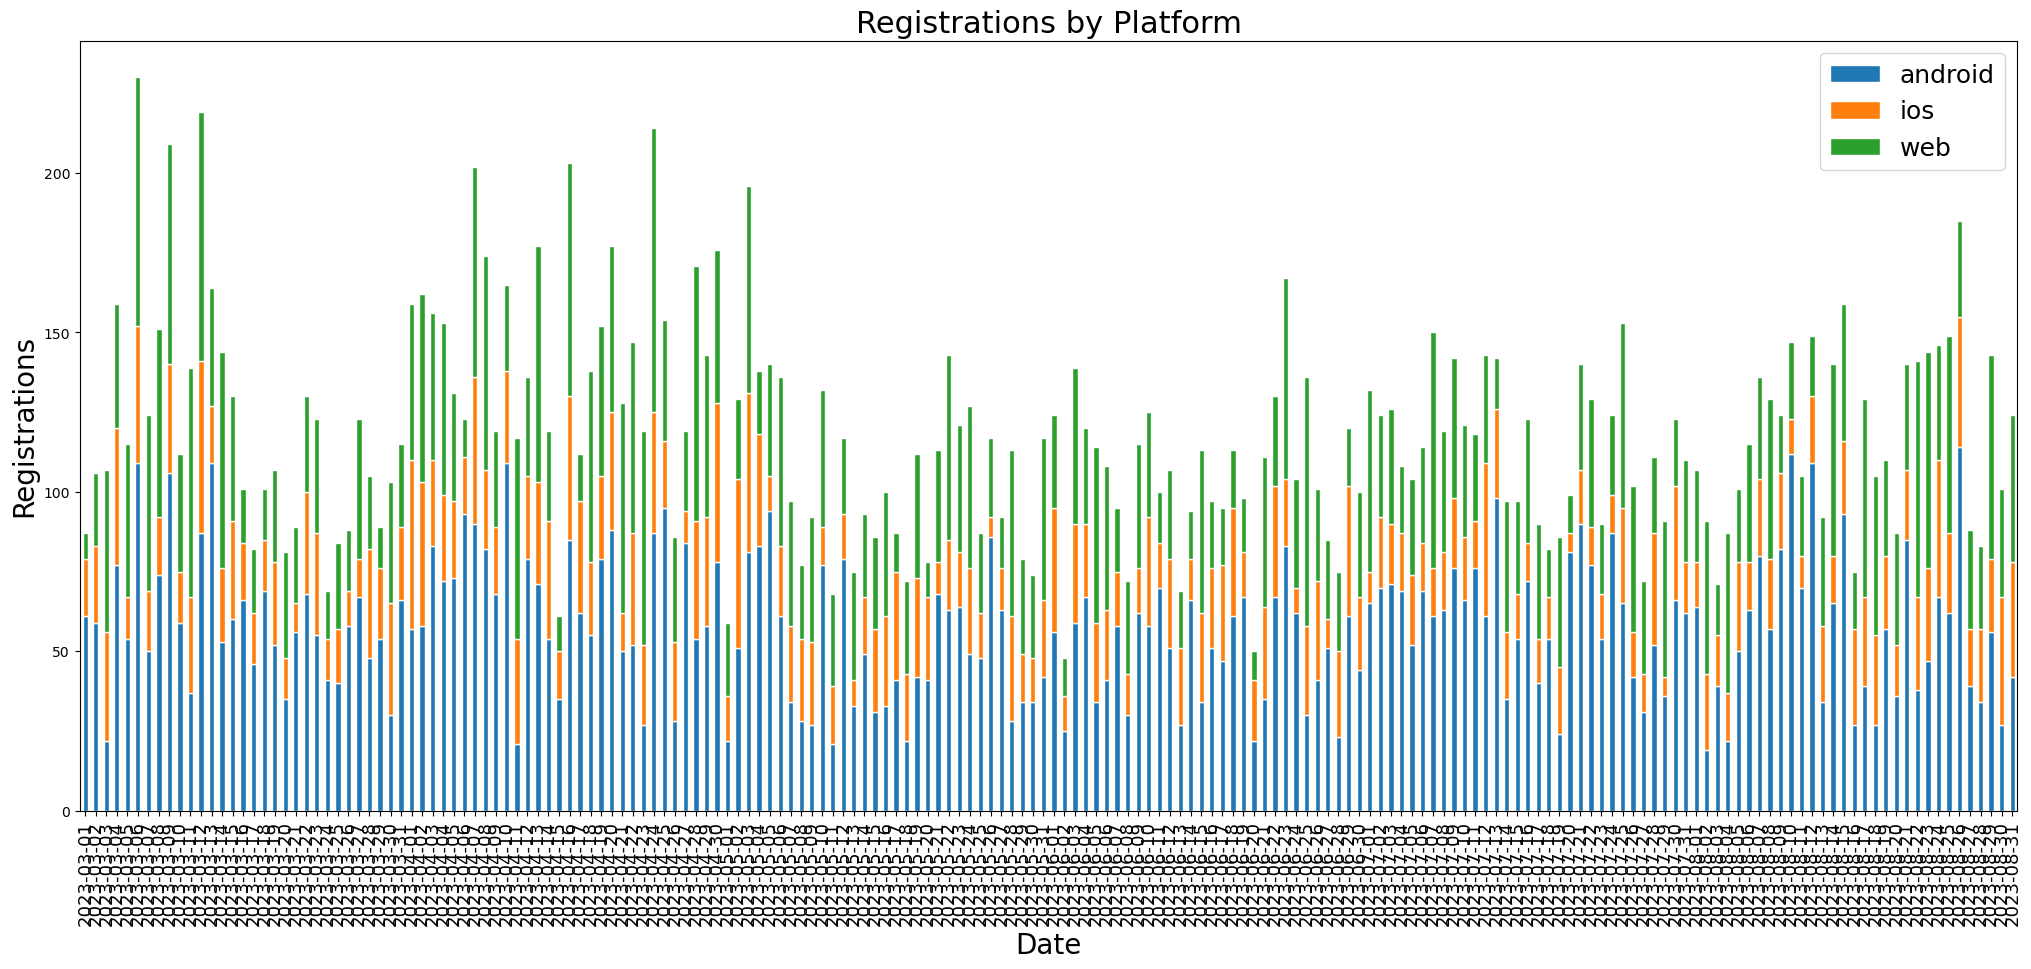

In [64]:
con2 = convers.pivot_table(values='registrations', index='date_group', columns='platform', aggfunc='sum', fill_value=0)

fig, ax = plt.subplots(figsize=(25, 10))
con2.plot(kind='bar', stacked=True, ax=ax, edgecolor='white')

ax.set_xlabel('Date', size=20)
ax.set_ylabel('Registrations', size=20)
ax.set_title('Registrations by Platform', size=22)
plt.legend(fontsize=18)
plt.xticks(rotation=90, size=13)

plt.savefig('./charts/registrations_by_platform.png')
plt.show()

#### Общая конверсия

In [103]:
over_conv = convers.drop(['conversion', 'platform'], axis=1).groupby('date_group').agg(visits=('visits', 'sum'), registrations=('registrations', 'sum')).reset_index()
over_conv['conversion'] = round(over_conv['registrations'] / over_conv['visits']  * 100, 2)
over_conv = over_conv.drop(['visits', 'registrations'], axis = 1)
over_conv['conversion'] = over_conv['conversion'].astype(int)

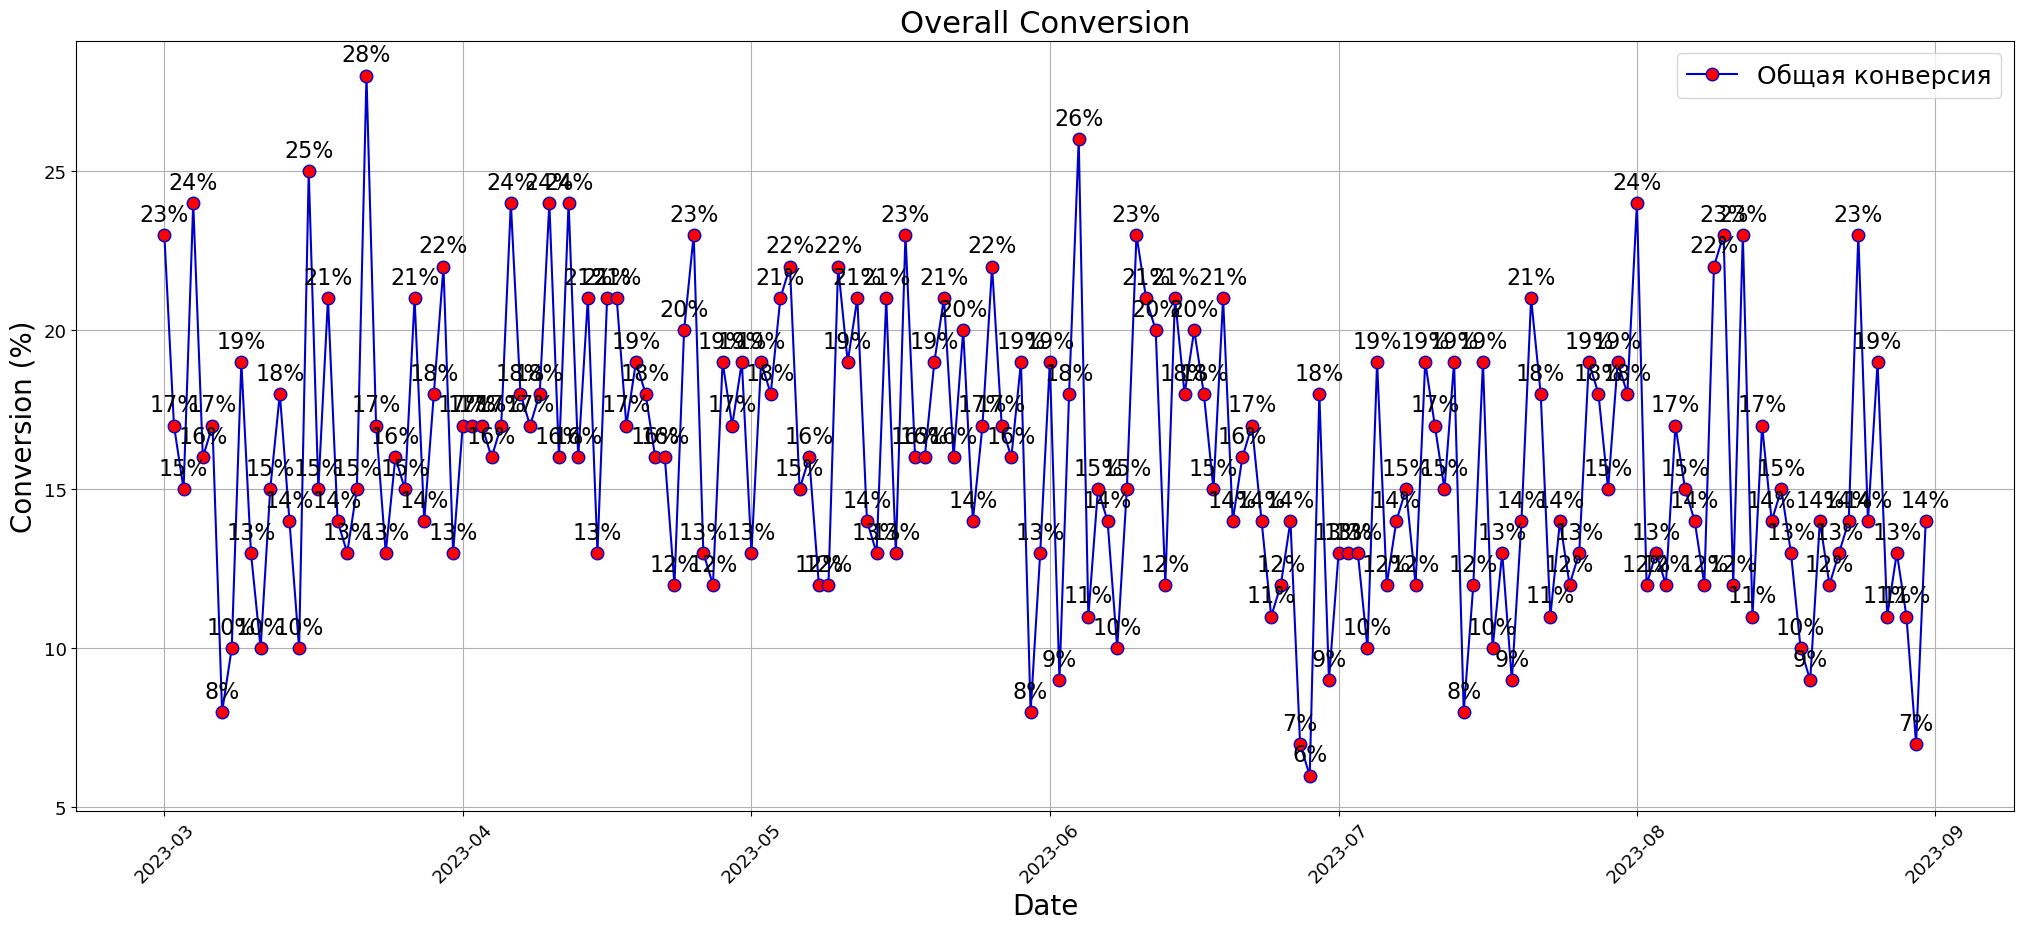

In [66]:
plt.figure(figsize=(25, 10))

plt.plot('date_group', 'conversion', data=over_conv, marker='o', markersize = 9, color='mediumblue', markerfacecolor='r', label='Общая конверсия')

plt.xlabel('Date', size=20)
plt.ylabel('Conversion (%)', size=20)
plt.title('Overall Conversion', size=22)
plt.legend(fontsize=18)
plt.xticks(rotation=45, size=13)
plt.yticks(size=13)
plt.grid()

for i, txt in enumerate(over_conv['conversion']):
    plt.annotate(f'{txt}%', (over_conv['date_group'][i], over_conv['conversion'][i]), 
                 textcoords="offset points", xytext=(0,10), ha='center', size=16)

plt.savefig('./charts/overall_conversion.png')
plt.show()

#### Конверсия по платформам

In [96]:
android_conv = convers.iloc[0::3].drop(['platform', 'visits', 'registrations'], axis=1)
ios_conv = convers.iloc[1::3].drop(['platform', 'visits', 'registrations'], axis=1)
web_conv = convers.iloc[2::3].drop(['platform', 'visits', 'registrations'], axis=1)

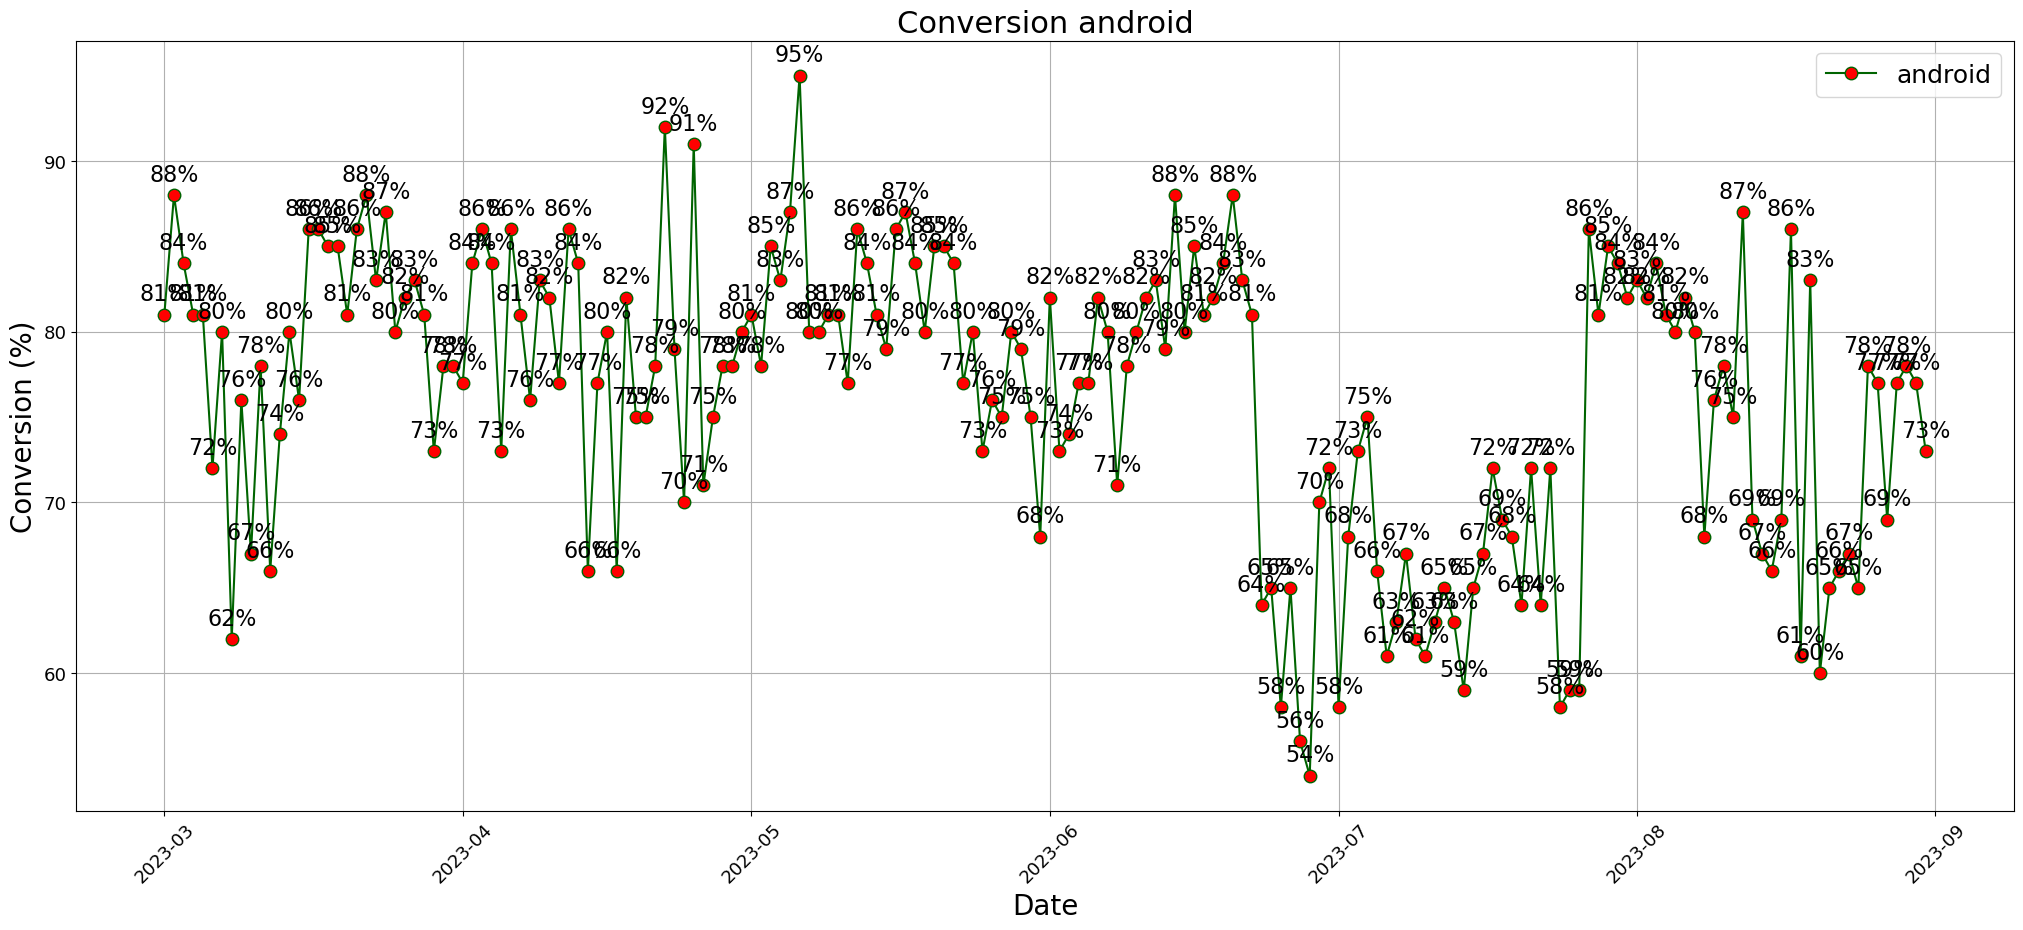

In [71]:
plt.figure(figsize=(25, 10))

plt.plot('date_group', 'conversion', data=android_conv, marker='o', color='darkgreen', markersize=9, markerfacecolor='r', label='android')

plt.xlabel('Date', size=20)
plt.ylabel('Conversion (%)', size=20)
plt.title('Conversion android', size=22)
plt.legend(fontsize=18)
plt.xticks(rotation=45, size=13)
plt.yticks(size=13)
plt.grid()

for i, txt in enumerate(android_conv['conversion']):
    plt.annotate(f'{txt}%', (android_conv['date_group'].iloc[i], android_conv['conversion'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center', size=16)

plt.savefig('./charts/android_conversion.png')
plt.show()

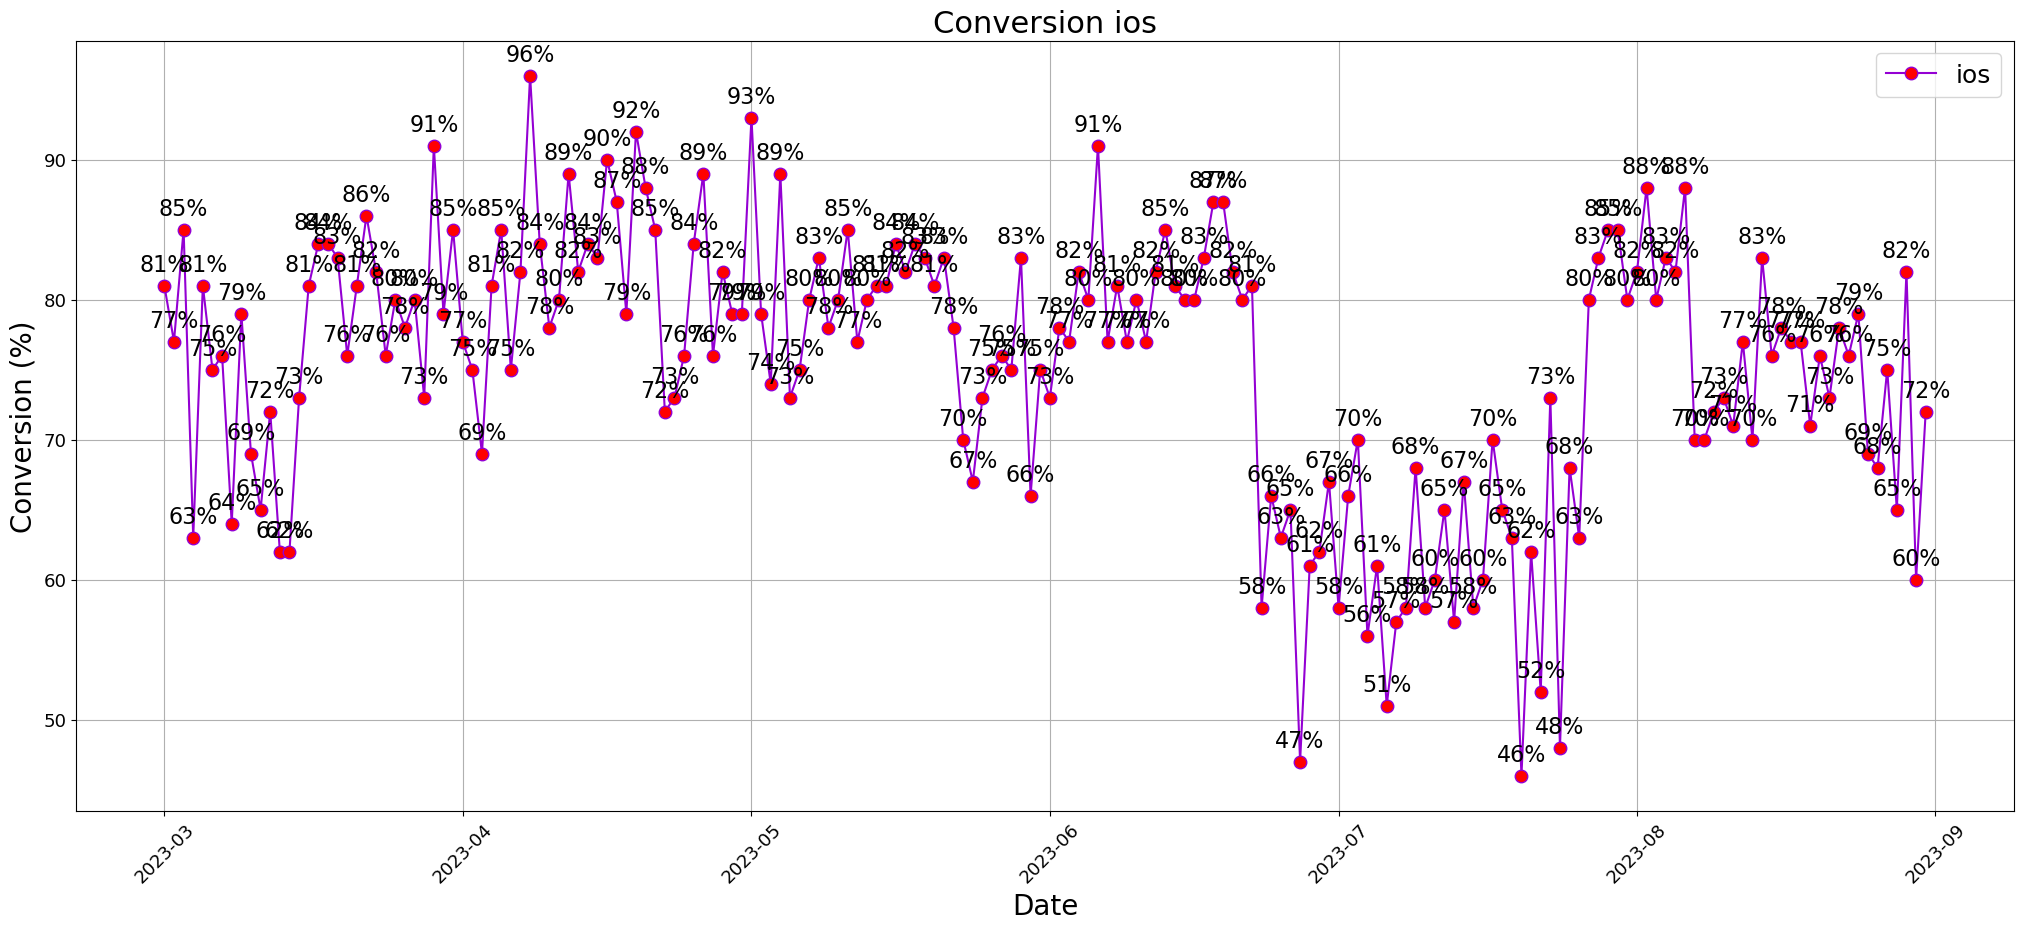

In [72]:
plt.figure(figsize=(25, 10))

plt.plot('date_group', 'conversion', data=ios_conv, marker='o', color='darkviolet', markersize=9, markerfacecolor='r', label='ios')

plt.xlabel('Date', size=20)
plt.ylabel('Conversion (%)', size=20)
plt.title('Conversion ios', size=22)
plt.legend(fontsize=18)
plt.xticks(rotation=45, size=13)
plt.yticks(size=13)
plt.grid()

for i, txt in enumerate(ios_conv['conversion']):
    plt.annotate(f'{txt}%', (ios_conv['date_group'].iloc[i], ios_conv['conversion'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center', size=16)

plt.savefig('./charts/ios_conversion.png')
plt.show()

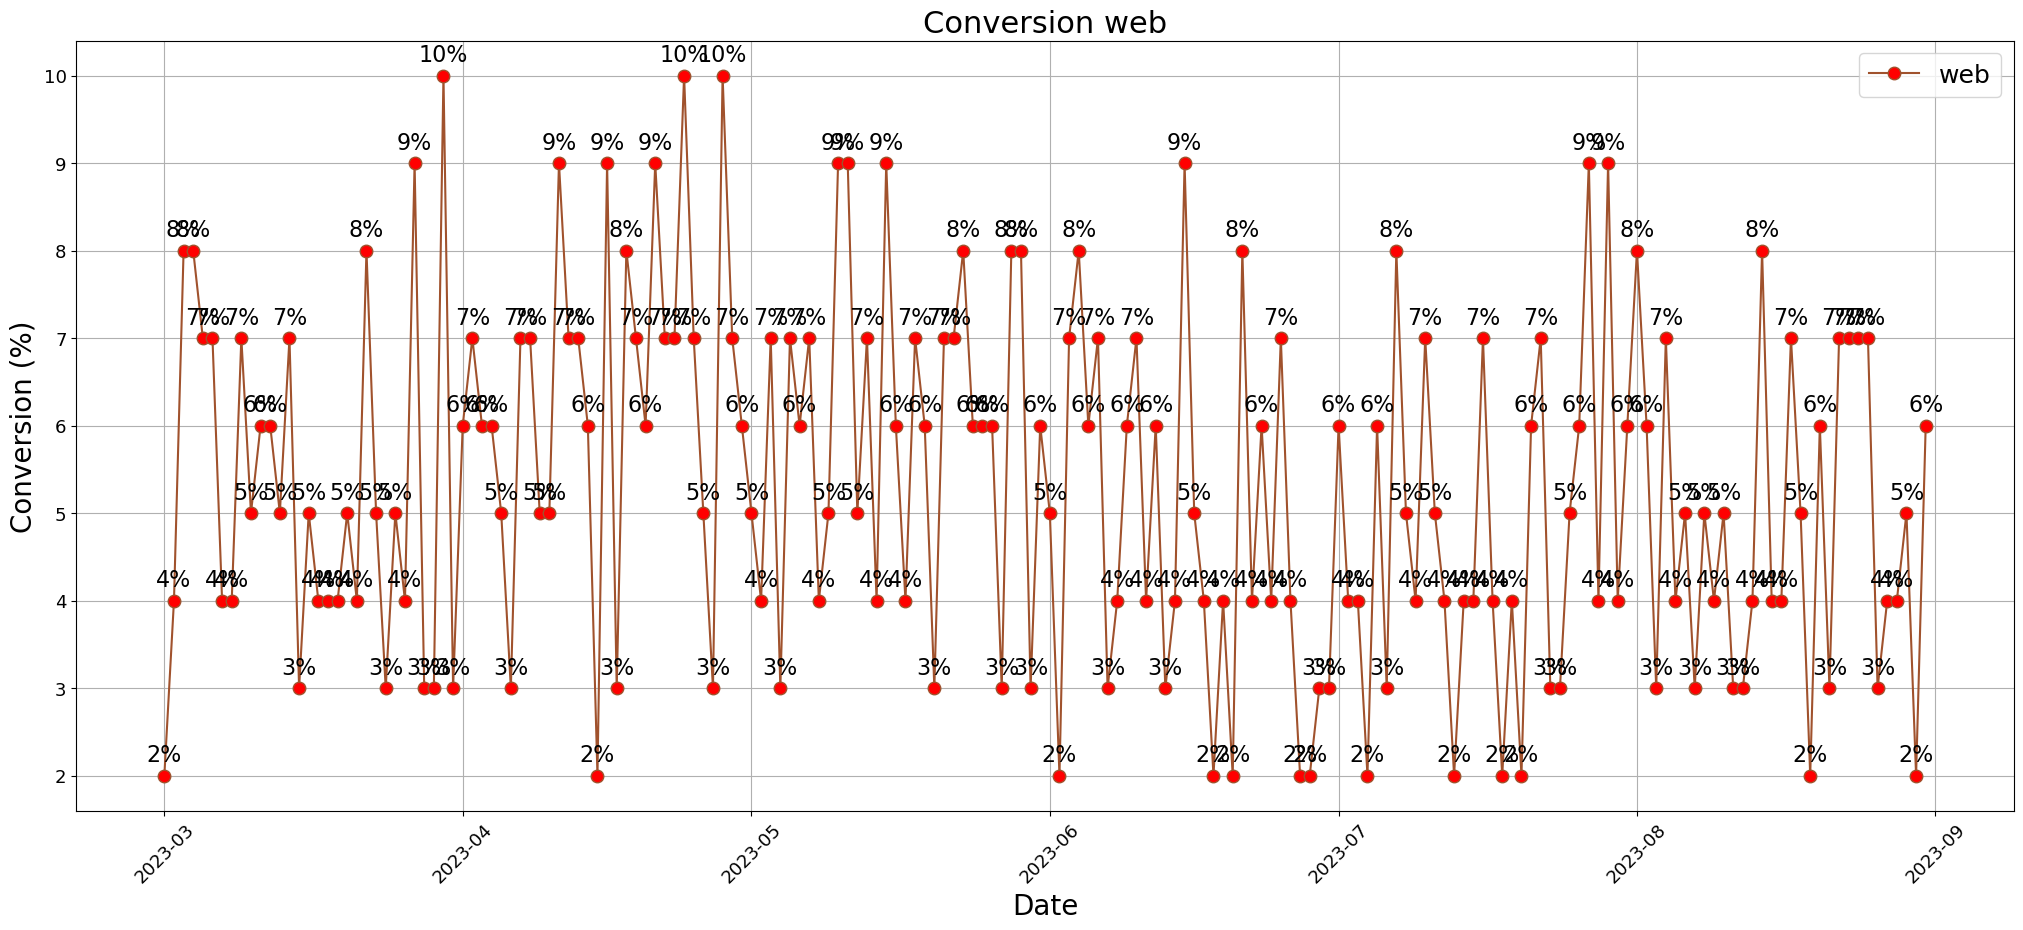

In [73]:
plt.figure(figsize=(25, 10))

plt.plot('date_group', 'conversion', data=web_conv, marker='o', color='sienna', markersize=9, markerfacecolor='r', label='web')

plt.xlabel('Date', size=20)
plt.ylabel('Conversion (%)', size=20)
plt.title('Conversion web', size=22)
plt.legend(fontsize=18)
plt.xticks(rotation=45, size=13)
plt.yticks(size=13)
plt.grid()

for i, txt in enumerate(web_conv['conversion']):
    plt.annotate(f'{txt}%', (web_conv['date_group'].iloc[i], web_conv['conversion'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center', size=16)

plt.savefig('./charts/web_conversion.png')
plt.show()

#### Стоимость рекламы

In [74]:
ads_graph = ads.drop(['utm_campaign'], axis=1)

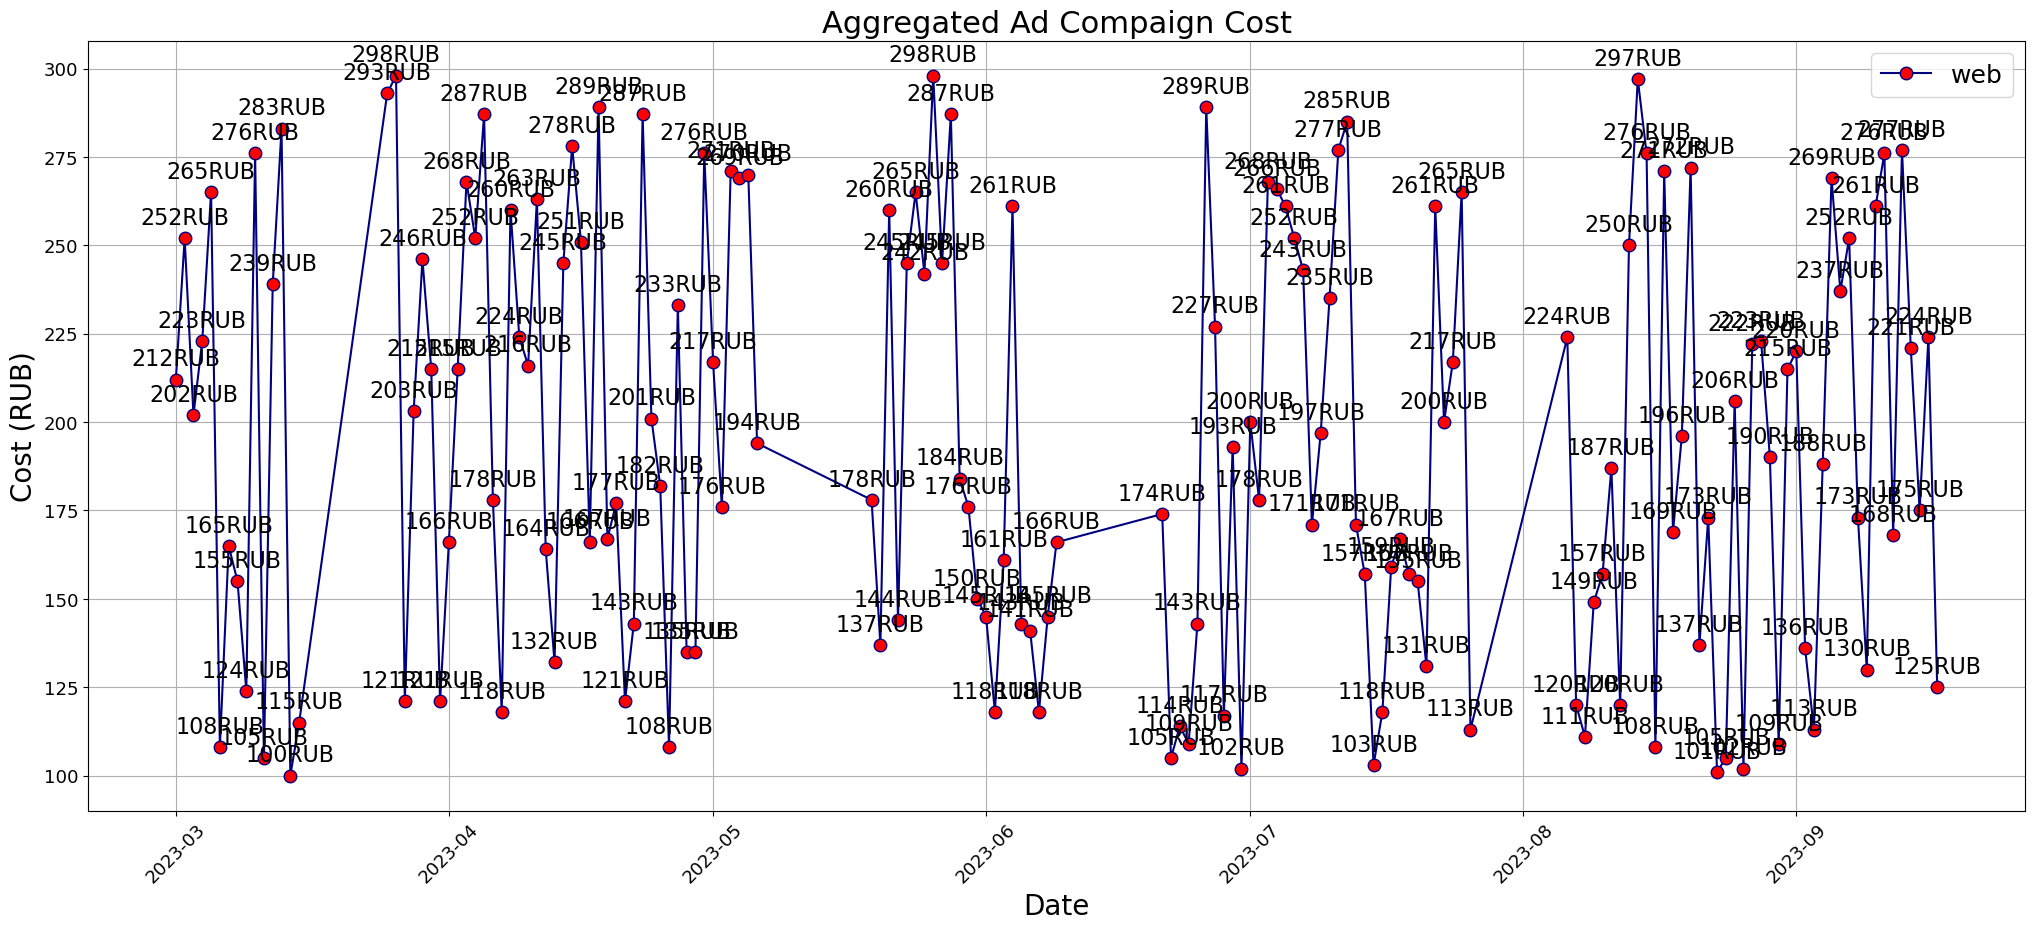

In [75]:
plt.figure(figsize=(25, 10))

plt.plot('date_group', 'cost', data=ads_graph, marker='o', color='navy', markersize=9, markerfacecolor='r', label='web')

plt.xlabel('Date', size=20)
plt.ylabel('Cost (RUB)', size=20)
plt.title('Aggregated Ad Compaign Cost', size=22)
plt.legend(fontsize=18)
plt.xticks(rotation=45, size=13)
plt.yticks(size=13)
plt.grid()

for i, txt in enumerate(ads_graph['cost']):
    plt.annotate(f'{txt}RUB', (ads_graph['date_group'][i], ads_graph['cost'][i]), 
                 textcoords="offset points", xytext=(0,10), ha='center', size=16)

plt.savefig('./charts/ad_cost.png')
plt.show()

#### Количество визитов в активные рекламные дни

In [99]:
vis_ads_utm = conv_ads.drop(['platform', 'registrations', 'conversion', 'cost'], axis=1).groupby(['date_group', 'utm_campaign']).agg(visits = ('visits', 'sum')).reset_index()
vis_ads_utm['average'] = round(vis_ads_utm['visits'].mean())

In [97]:
utm = (vis_ads_utm.groupby(['utm_campaign'], as_index=False)
        .agg(**{'first':('date_group', 'first'),
                'last': ('date_group', 'last')}))

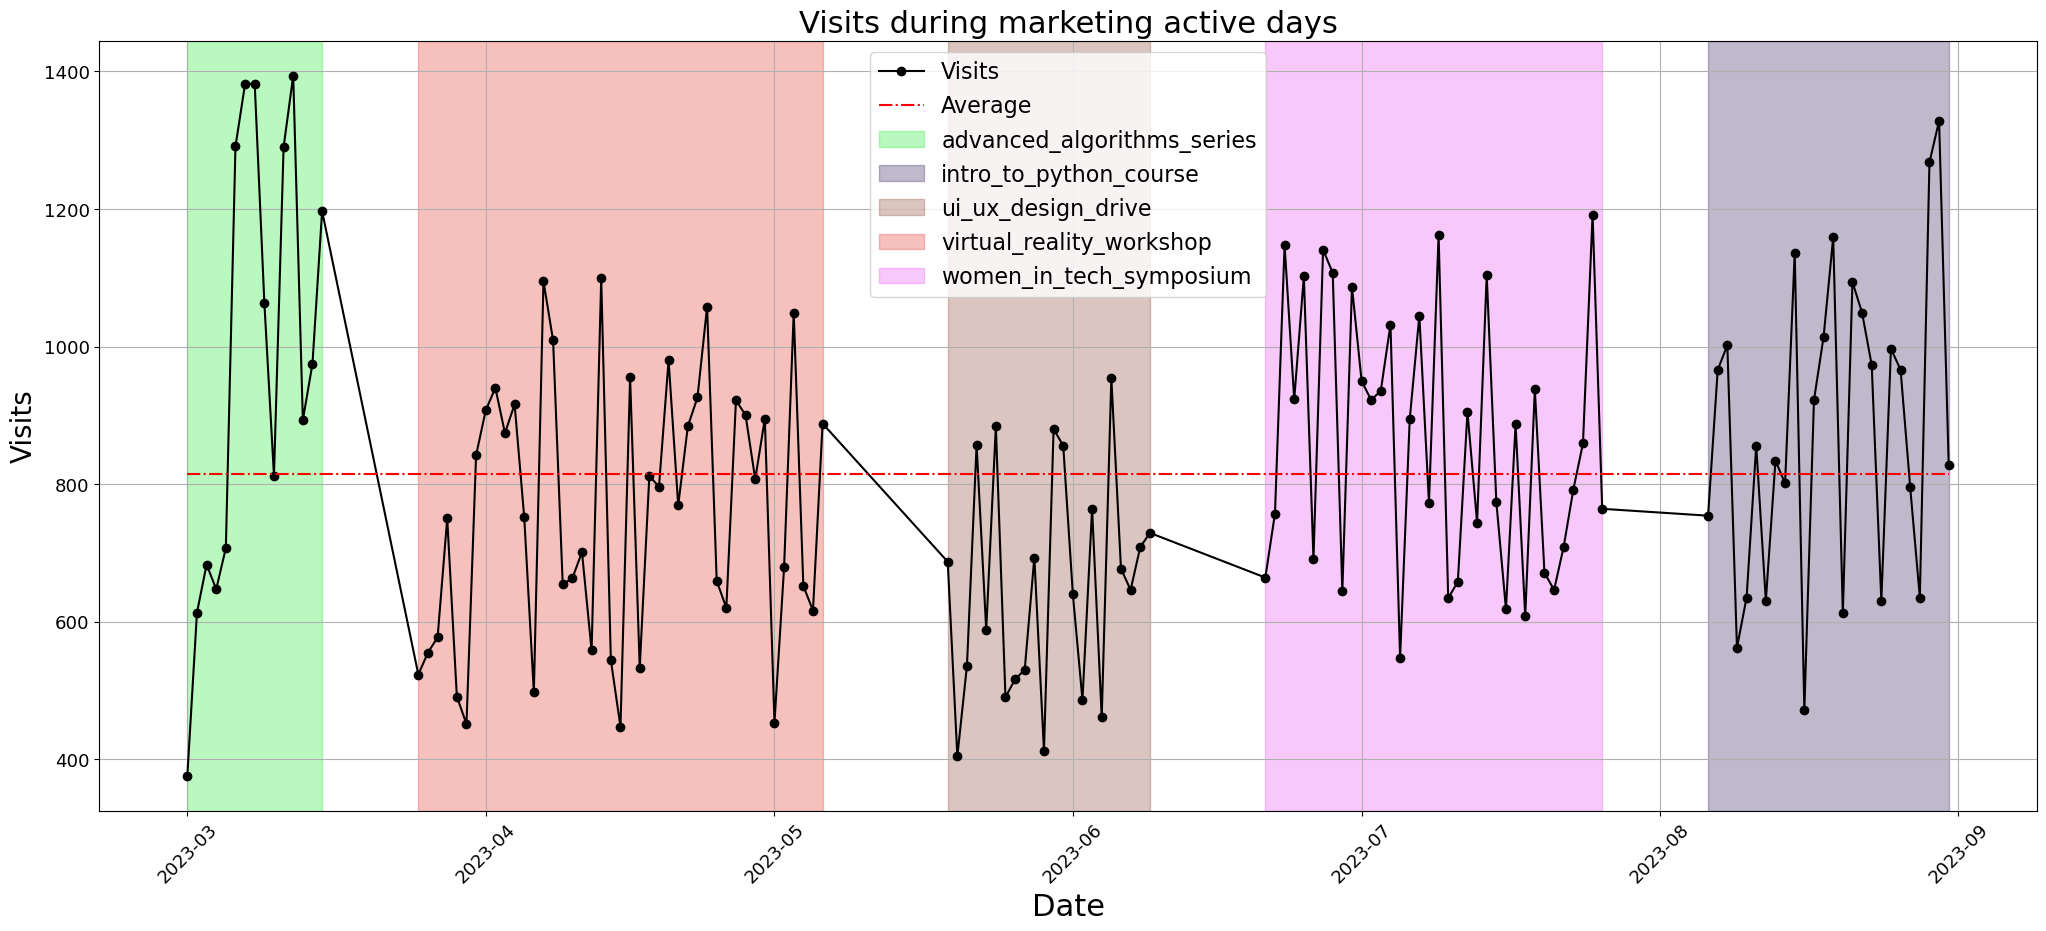

In [43]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(vis_ads_utm['date_group'], vis_ads_utm['visits'], color='black', marker='o',label='Visits')
ax.plot(vis_ads_utm['date_group'], vis_ads_utm['average'], color='r', linestyle = '-.', label='Average')

plt.xlabel('Date', size=22)
plt.ylabel('Visits', size=20)
plt.title('Visits during marketing active days', size=22)
plt.xticks(rotation=45, size=13)
plt.yticks(size=13)
plt.grid()

utm_started = utm['first'].to_list()
utm_ended = utm['last'].to_list()
for i in range(len(utm)):
    ax.axvspan(utm_started[i], utm_ended[i], alpha=0.3, color=np.random.rand(3,), label=utm['utm_campaign'].to_list()[i] )

plt.legend(fontsize=16)

plt.savefig('./charts/visits_during_marketing.png')
plt.show()

#### Количество регистраций в активные рекламные дни

In [101]:
reg_ads_utm = conv_ads.drop(['platform', 'visits', 'conversion', 'cost'], axis=1).groupby(['date_group', 'utm_campaign']).agg(registrations = ('registrations', 'sum')).reset_index()
reg_ads_utm['average'] = round(reg_ads_utm['registrations'].mean())

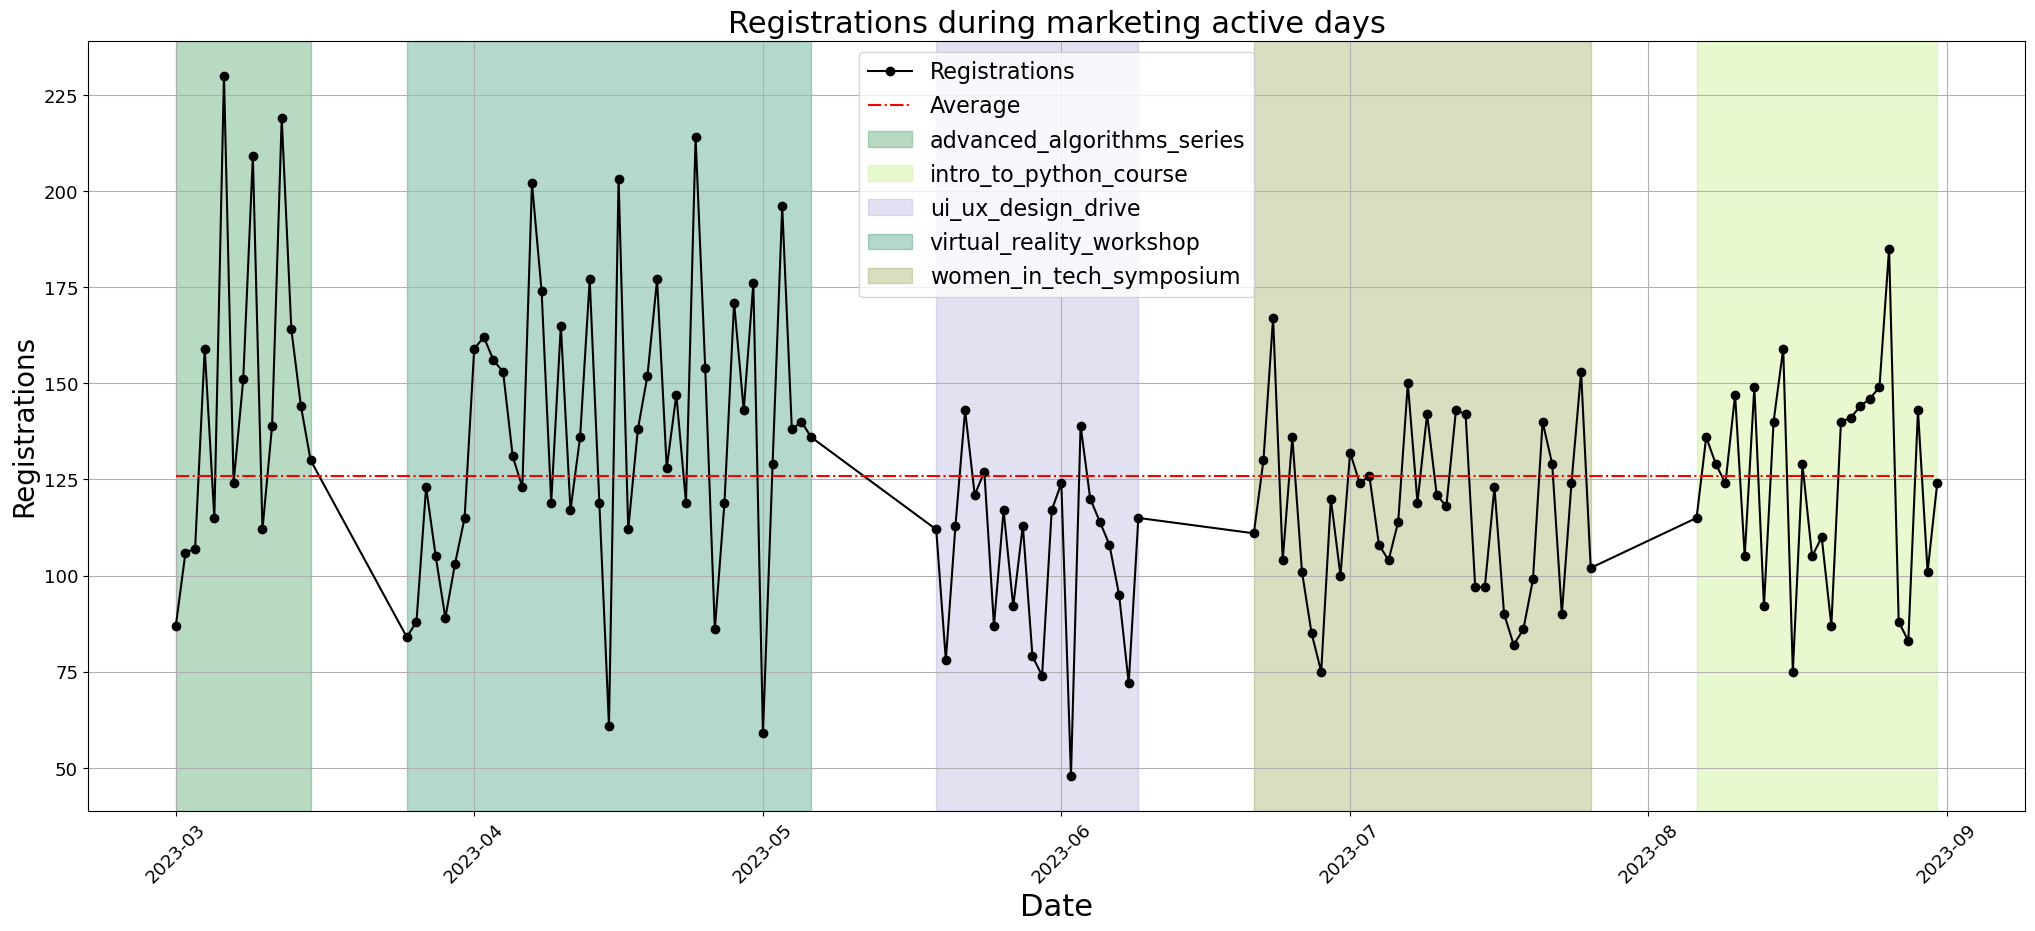

In [45]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(reg_ads_utm['date_group'], reg_ads_utm['registrations'], color='black', marker='o',label='Registrations')
ax.plot(reg_ads_utm['date_group'], reg_ads_utm['average'], color='r', linestyle = '-.', label='Average')

plt.xlabel('Date', size=22)
plt.ylabel('Registrations', size=20)
plt.title('Registrations during marketing active days', size=22)
plt.xticks(rotation=45, size=13)
plt.yticks(size=13)
plt.grid()

utm_started = utm['first'].to_list()
utm_ended = utm['last'].to_list()
for i in range(len(utm)):
    ax.axvspan(utm_started[i], utm_ended[i], alpha=0.3, color=np.random.rand(3,), label=utm['utm_campaign'].to_list()[i] )

plt.legend(fontsize=16)

plt.savefig('./charts/registrations_during_marketing.png')
plt.show()